In [39]:
import numpy as np 
import pandas as pd 
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [40]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

In [41]:
from tensorflow.keras.utils import to_categorical
import random
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

#set random seed for the session and also for tensorflow that runs in background for keras

In [42]:
# 载入数据
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [43]:
train['Sentiment'].unique()
train.info()
train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


(156060, 4)

## 清理评论，令牌化、词性化

In [44]:
def clean_sentences(df):
    
    reviews = []
    
    for sent in tqdm(df['Phrase']):
        
        # 移除HTMLP标签
        review_text = BeautifulSoup(sent).get_text()
        
        # 移除非字母
        review_text = re.sub("[^a-zA-Z]", " ", review_text)
        
        # 令牌化
        words = word_tokenize(review_text.lower())
        
        # 词形化
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        reviews.append(lemma_words)
    
    return (reviews)

In [45]:
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences), len(test_sentences))

100%|██████████████████████████████████████████████████████████████████████████| 66292/66292 [00:18<00:00, 3502.88it/s]


156060 66292


### 收集相关数据并转换为one-hot 编码， 切分数据


In [46]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [51]:
type(X_train),  X_train[:5]

(list,
 [['looking',
   'for',
   'an',
   'intelligent',
   'movie',
   'in',
   'which',
   'you',
   'can',
   'release',
   'your',
   'pent',
   'up',
   'anger'],
  ['what',
   'with',
   'the',
   'incessant',
   'lounge',
   'music',
   'playing',
   'in',
   'the',
   'film',
   's',
   'background',
   'you',
   'may',
   'mistake',
   'love',
   'liza',
   'for',
   'an',
   'adam',
   'sandler',
   'chanukah',
   'song'],
  ['with', 'spider', 'man'],
  ['a', 'long'],
  ['most']])

In [52]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████████████████████████████████████████████████████████████████| 124848/124848 [00:00<00:00, 243514.41it/s]

13737
48


## Actual tokenizer of keras and convert to sequences
Keras 令牌化和转换为序列

In [53]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

# LSTM 网络需要输入长度一致，不够的数据用0填充---Padding
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [55]:
type(X_train),  X_train[:2]

(numpy.ndarray,
 array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,  300,   14,   15,  430,   13,    8,   81,   20,   62,  906,
           60, 6700,   43, 2875],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,   55,   11,    1, 3624, 9989,  215,  669,    8,
            1,   12,    7, 1518,   20,  123, 1689,   78, 5956,   14,   15,
          910, 1057, 8405,  682]]))

In [56]:
## Early stopping to prevent overfitting 提前停止防止过拟合
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [57]:
#Model using Keras LSTM

#Multilayer Perceptron (MLP) for multi-class softmax classification:
#Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
#This architecture is specially designed to work on sequence data.
#It fits perfectly for many NLP tasks like tagging and text classification.
#It treats the text as a sequence rather than a bag of words or as ngrams.

#Here’s a possible model definition:

model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 300)           4121100   
_________________________________________________________________
lstm (LSTM)                  (None, 48, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 4,397,161
Trainable params: 4,397,161
Non-trainable params: 0
______________________________________________

# 训练模型

In [58]:
#This is done for learning purpose only. One can play around with different hyper parameters combinations
#and try increase the accuracy even more. For example, a different learning rate, an extra dense layer 
# before output layer, etc. Cross validation could be used to evaluate the model and grid search 
# further to find unique combination of parameters that give maximum accuracy. This model has a validation
#accuracy of around 66.5%

history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 306s 2ms/sample - loss: 1.0419 - accuracy: 0.5824 - val_loss: 0.8636 - val_accuracy: 0.6460
Epoch 2/6
124848/124848 [==============================] - 312s 2ms/sample - loss: 0.8264 - accuracy: 0.6610 - val_loss: 0.8153 - val_accuracy: 0.6664
Epoch 3/6
124848/124848 [==============================] - 313s 3ms/sample - loss: 0.7576 - accuracy: 0.6870 - val_loss: 0.8119 - val_accuracy: 0.6725
Epoch 4/6
124848/124848 [==============================] - 292s 2ms/sample - loss: 0.7185 - accuracy: 0.7020 - val_loss: 0.8168 - val_accuracy: 0.6744
Epoch 5/6
124848/124848 [==============================] - 338s 3ms/sample - loss: 0.6951 - accuracy: 0.7083 - val_loss: 0.8229 - val_accuracy: 0.6710
Epoch 6/6
124848/124848 [==============================] - 507s 4ms/sample - loss: 0.6762 - accuracy

模型训练： accuracy: 0.7178
可以看出迭代到三次时，训练误差持续减少，而实际误差开始增加，出现过拟合

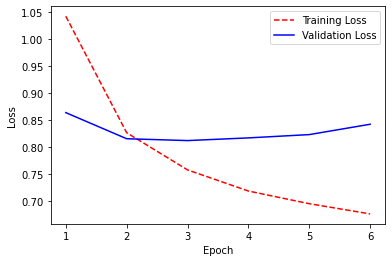

In [59]:
# 结果可视化
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

可视化的结果也可以看出过拟合情形在迭代2次后发生

In [62]:
y_pred = model.predict(X_val)
y_pred

array([[2.74306331e-07, 1.36704097e-04, 1.10745765e-01, 7.31555581e-01,
        1.57561734e-01],
       [2.81449016e-02, 4.60610509e-01, 4.90499735e-01, 2.06187777e-02,
        1.26088227e-04],
       [9.62138103e-09, 1.98584909e-04, 9.97380912e-01, 2.42048479e-03,
        6.51814114e-09],
       ...,
       [6.39360607e-01, 3.35015982e-01, 2.53175702e-02, 2.97864259e-04,
        7.97811208e-06],
       [3.17824743e-04, 4.89765704e-02, 8.98706555e-01, 5.19187078e-02,
        8.03908333e-05],
       [2.79621727e-05, 9.66503576e-04, 9.11222100e-02, 5.57022095e-01,
        3.50861192e-01]], dtype=float32)

In [68]:
type(history)

tensorflow.python.keras.callbacks.History

https://www.kaggle.com/chiranjeevbit/movie-review-prediction